<center>
 <font size="5"> <b>This notebook illustrates how to perform linear regression in R </b></font>
</center>

We consider a simple linear regression with one explanatory (regressor) variables $x$ (straight line fit). The response variable is called $y$. The statistical model is:

$$y(x; a, b, \varepsilon) = a x + b + \varepsilon$$

where $\varepsilon$ is the error. We assume that the error follows a normal distribution with mean $0$ and standard deviation $\sigma$:

$$\varepsilon \sim {\cal N}(0, \sigma)$$

The parameters to estimate are the slope $a$ and the intercept $b$. The estimators will be denoted as $\hat{a}$ and $\hat{b}$. The estimation is done by minimizing the sum of squared residuals 

$$\sum_{i=1} \left(y_i - (ax_i+b)\right)^2 = \sum_i \varepsilon_i^2$$

where $x_i$ and $y_i$ are the $i^{th}$ measured values of $x$ and $y$. We also assume that the errors of all measurements are independent. 

The purpose is to see how R can be used to solve this problem, that is find $\hat{a}$ and $\hat{b}$ as well as their covariance matrix $U$:

$$U=\begin{pmatrix} \sigma_\hat{a}^2 & cov(\hat{a}, \hat{b})\\cov(\hat{a}, \hat{b}) & \sigma_\hat{b}^2\end{pmatrix}$$

For this, three methods can be used. We will perform calculations for all of them and compare results. Hopefully, we'll find the same !

In all cases, we consider that the explanatory variable $x$ takes four values ($1$, $2$, $3$ and $4$) and that $\sigma=0.5$. We generate a dataset for $a=2$ and $b=0.4$. 

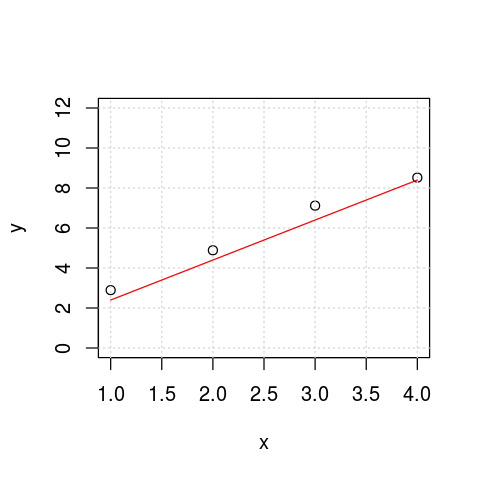

In [1]:
# Set seed to constant value so that results are reproducible
set.seed(1485)

# Create explanatory variable vector
x <- c(1,2,3,4)

# Generate pseudo-data
slope <- 2
intercept <- 0.4
sigma <- 0.5
y <- slope*x + intercept + rnorm(length(x), 0, sigma)

# Plot data
options(repr.plot.width=4, repr.plot.height=4) # This sets the size of the plot
plot(y~x, ylim=c(0, 12))
grid()

# Plot true line
lines(x, slope*x + intercept, col="red")



### Method 1: Explicit analytical calculation

We know (see lecture notes) that the estimators are given by 

$$\hat{a} = \frac{n\sum_i x_i y_i - \sum_i\sum_j x_i y_j}{n\sum_i x_i^2 - \sum_i\sum_j x_i x_j}$$

and 

$$\hat{b} = \frac{\sum_i\sum_j x_i^2y_j - \sum_i\sum_j x_i y_i x_j}{n\sum_i x_i^2 - \sum_i\sum_j x_i x_j}$$

and that the covariance matrix is given by

$$U = \frac{\sigma^2}{n\sum_i x_i^2 - \left(\sum_i x_i\right)^2}\begin{pmatrix} n & -\sum_i x_i\\-\sum_i x_i & \sum_i x_i^2\end{pmatrix}$$

Notice that in the expression of $U$, the error standard deviation $\sigma$ appears. In practical cases, we often don't know this value. So, rather than using the unknown true value we use the unbiased estimator (see p. 545 (chap "The general linear model" of Kendall's volume 2A):

$$\hat{\sigma^2} = \frac{\sum_i \left(y_i - \hat{y}_i\right)^2}{n-2}$$

where $\hat{y}_i = \hat{a}x_i+\hat{b}$ is the best fit value of $y_i$.

In [2]:
n <- length(x)

# Compute double sums
num1 <- 0
num2 <- 0
num3 <- 0
denom <- 0 
for(i in 1:n) {
    for (j in 1:n) {
        num1 <- num1 + x[i]*y[j]
        num2 <- num2 + x[i]^2*y[j]
        num3 <- num3 + x[i]*y[i]*x[j]
        denom <- denom + x[i]*x[j]
    }
}

denom <- n*sum(x^2) - denom

aHatMethod1 <- (n*sum(x*y) - num1)/denom
bHatMethod1 <- (num2 - num3)/denom

sigmaSqHat <- 1/(n-2)*sum((y-(aHatMethod1*x + bHatMethod1))^2)
Ufactor <- sigmaSqHat/(n*sum(x^2)-sum(x)^2)
U11Method1 <- Ufactor*n
U12Method1 <- Ufactor*-1*sum(x)
U22Method1 <- Ufactor*sum(x^2)

print("**************Results (method 1)*********************")
sprintf("aHat=%f ; bHat=%f", aHatMethod1, bHatMethod1)
sprintf("var[aHat]=%f; var[bHat]=%f; cov(aHat,bHat)=%f", U11Method1, U22Method1, U12Method1)
print("*****************************************************")

[1] "**************Results (method 1)*********************"


[1] "aHat=1.910847 ; bHat=1.076623"

[1] "var[aHat]=0.014435; var[bHat]=0.108261; cov(aHat,bHat)=-0.036087"

[1] "*****************************************************"


### Method 2: Analytical calculations with matrices

Let's call $\theta=\begin{pmatrix}a\\b\end{pmatrix}$ the parameter vector and $X$ the regressors matrix:

$$X = \begin{pmatrix}x_1 & 1\\\vdots & \vdots\\x_n & 1\end{pmatrix}$$

The estimators are given by

$$\hat{\theta} = \left(X^T X\right)^{-1}X^Ty$$

where $X^T$ is the transpose of $X$. The correlation matrix of the $\theta$s is:

$$U=\left(A^T V^{-1} A\right)^{-1}$$

where $V$ is the covariance matrix of the $y$s. As the errors are independent and normally distributed with variance $\sigma^2$, we have

$$V=\begin{pmatrix} \sigma^2 & \cdots & 0 \\ \vdots & & \vdots \\ 0 & \cdots & \sigma^2\end{pmatrix}$$

We can thus rewrite $U$ as

$$U = \sigma^2 \left(A^TA\right)^{-1}$$

As before, as the value of $\sigma$ is generally not known, we use the estimator $\hat{\sigma^2}$

In [3]:
X <- cbind(x, 1)
thetaHat <- solve(t(X) %*% X) %*% t(X) %*% y
covMatrixMethod2 <- sigmaSqHat * solve(t(X) %*% X)

aHatMethod2 <- thetaHat[1]
bHatMethod2 <- thetaHat[2]
U11Method2 <- covMatrixMethod2[1, 1]
U12Method2 <- covMatrixMethod2[1, 2]
U22Method2 <- covMatrixMethod2[2, 2]

print("**************Results (method 2)*********************")
sprintf("aHat=%f ; bHat=%f", aHatMethod2, bHatMethod2)
sprintf("var[aHat]=%f; var[bHat]=%f; cov(aHat,bHat)=%f", U11Method2, U22Method2, U12Method2)
print("*****************************************************")

[1] "**************Results (method 2)*********************"


[1] "aHat=1.910847 ; bHat=1.076623"

[1] "var[aHat]=0.014435; var[bHat]=0.108261; cov(aHat,bHat)=-0.036087"

[1] "*****************************************************"


Results found with method 2 are the same as the ones found with method 1, but the number of lines of code is much smaller !!

It's also possible to perform calculations with the built-in lm() function of R. That's what method 3 does.

### Method 3: Use the lm function of R 

In [4]:
# Make and print datas
ds <- data.frame(x = x, y = y)
ds.lm <- lm(y~x, data=ds)
coeffs <- coefficients(ds.lm)
covMatrixMethod3 <- vcov(ds.lm)

aHatMethod3 <- coeffs[2]
bHatMethod3 <- coeffs[1]
U11Method3 <- covMatrixMethod3[1, 1]
U12Method3 <- covMatrixMethod3[1, 2]
U22Method3 <- covMatrixMethod3[2, 2]

print("**************Results (method 3)*********************")
sprintf("aHat=%f ; bHat=%f", aHatMethod3, bHatMethod3)
sprintf("var[aHat]=%f; var[bHat]=%f; cov(aHat,bHat)=%f", U22Method3, U11Method3, U12Method3)
print("*****************************************************")

#print("Printing model summary")
#summary(ds.lm)

# Another way to retrieve the coefficients
#ds.lm$coef

#print("Printing fit rsquared")
#summary(ds.lm)$r.squared

#print("Printing vcov")
#vcov(ds.lm)


[1] "**************Results (method 3)*********************"


[1] "aHat=1.910847 ; bHat=1.076623"

[1] "var[aHat]=0.014435; var[bHat]=0.108261; cov(aHat,bHat)=-0.036087"

[1] "*****************************************************"


### Conclusion

The three methods give the same results !!

It is useful to make a plot to visualize the result of the fit.

For the confidence belt, see demonstration on page 740 (chap "Analysis and Diagnostics for the linear model")of Kendall's volume 2A.

In [5]:
aHat <- aHatMethod3
bHat <- bHatMethod3
varaHat <- U22Method3
varbHat <- U11Method3
covaHatbHat <- U12Method3

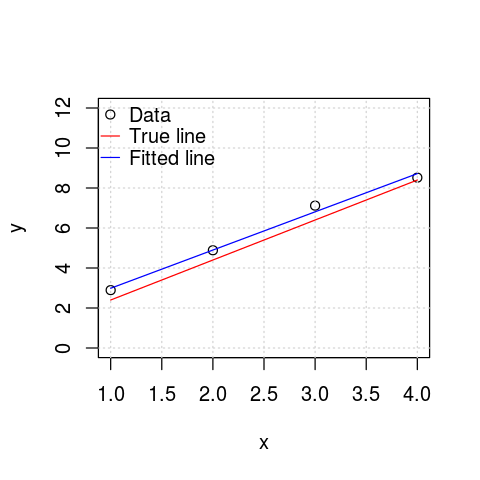

In [82]:
# Start by re-plotting the data and the true line
plot(y~x, ylim=c(0, 12))
grid()
lines(x, slope*x + intercept, col="red")

# Plot fitted line
# method 1
yt <- aHat*x+bHat
lines(x, yt, col="blue", lty=1)
# method 2
#abline(ds.lm, col="green")

# Adding legend to plot
legend("topleft", legend=c("Data", "True line", "Fitted line"), 
       col=c("black", "red", "blue"), lty=c(NA,1,1), pch=c(1, NA, NA), 
       bty = "n", y.intersp=2)

# Plotting error band
#prd2<-predict(ds.lm,interval = c("confidence"), level = 0.6827, type="response")
#prd2
#lines(x,prd2[,2],col="blue",lty=2)
#lines(x,prd2[,3],col="blue",lty=2)

# Note: the predict() function performs calculation as follows (here we give only up variations)
#MSE=sigmaSqHat
#t.quantiles <- qt(.84135, n-2)
#SE_predict = sqrt(MSE)*sqrt(1/n+(mean(x)-x)^2/sum((x - mean(x))^2))
#yt + SE_predict*t.quantiles